# Notebook for Discussion on "pH" Effects on Diatoms #

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Based on the various laboratory results, we have selected the Herve results on Thalassiosira w. to use for an exploration of the impacts of "pH" on diatoms in SalishSeaCast.  These results look like (from Karyn).

In [2]:
#umax (d-1)
pH = np.array([6.4, 6.8, 7.3, 7.8, 8.2, 8.5])
Herve_GR = np.array([0.5, 0.55, 0.7, 0.78, 0.61, 0.5])
Herve_Err1 = ([0.08, 0.14, 0.20, 0.20, 0.21, 0.15]) # - Error range 0.08 to 0.21
Herve_Err2 = ([0.11, 0.11, 0.15, 0.27, 0.10, 0.12]) # + Error range 0.10 to 0.27

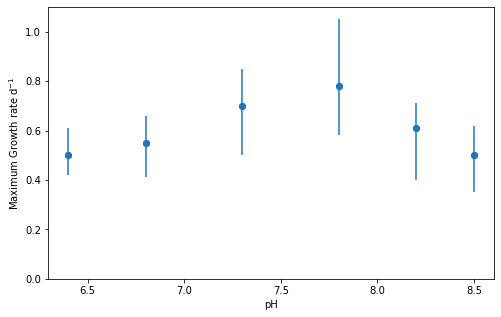

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.scatter(pH, Herve_GR, marker='o', linestyle='None')
ax.errorbar(pH, Herve_GR, yerr=(Herve_Err1, Herve_Err2), marker='o', linestyle='None')

ax.set_xlabel('pH')
ax.set_ylabel('Maximum Growth rate d$^{-1}$')
ax.set_ylim(0, 1.1);

We believe that the downtrend at high pH is not due to pH per say, but due to a lack of dissolved CO2 for the diatoms to uptake.  This process would be like a nutrient limitation and could be represented by a Michaelis-Menton type relation [co2]/(k + [co2]).

co2 can be calculated from pH using the mocsy code provided we set one other parameter.  Here, as a first step, I use a tanh function that comes from the classic carbon speciation as a function of pH plot.

co2 = 0.5 * (1 - np.tanh((pH - 6.5)))

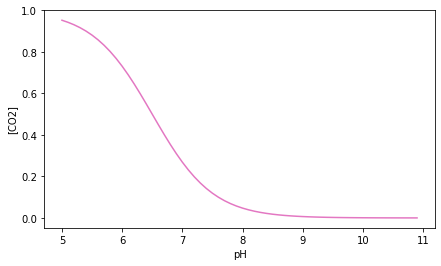

In [38]:
pHs = np.arange(5, 11, 0.1)
co2 = 0.5*(1 - np.tanh((pHs-6.5)))

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(pHs, co2, c='tab:pink')

ax.set_xlabel('pH')
ax.set_ylabel('[CO2]');

Using this estimate for [CO2] we can construct a MM on it and calculate growth rate as a function of pH

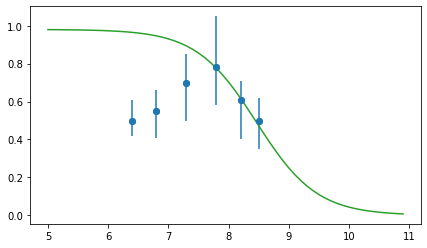

In [39]:
## MMenton using CO2
mm = 1.*co2/(0.02 + co2)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.scatter(pH, Herve_GR, marker='o', linestyle='None')
ax.errorbar(pH, Herve_GR, yerr=(Herve_Err1, Herve_Err2), marker='o', linestyle='None')
ax.plot(pHs, mm, color='tab:green');

Now the question is what to do for the low pH end.  This part has less theoretical basis.  It looks like a kind of tanh curve, with a low pH tail at about 0.4 and a high pH piece at about 1.

growth = a + b * tanh((ph-7)/c)

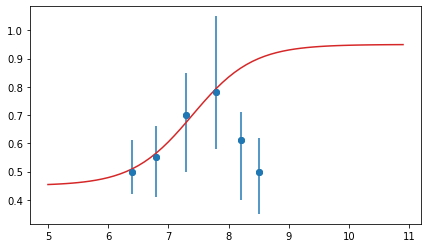

In [40]:
## Tanh using pH
tt = 0.45 + 0.5/2 * (1 + np.tanh((pHs - 7.4) / 1))
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.scatter(pH, Herve_GR, marker='o', linestyle='None')
ax.errorbar(pH, Herve_GR, yerr=(Herve_Err1, Herve_Err2), marker='o', linestyle='None')
plt.plot(pHs, tt, color='tab:red');

There are many different functional forms we could use.  We could base them on [H+] or [OH-] but not knowing which, maybe go simple?

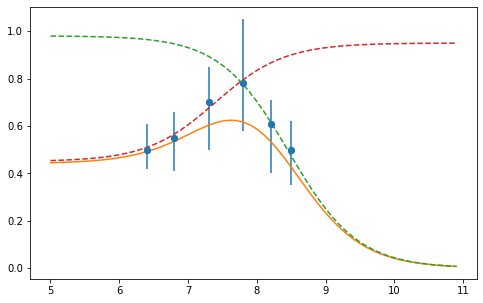

In [41]:
## and Together
growth = mm * tt
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(pH, Herve_GR, marker='o',linestyle='None')
ax.errorbar(pH, Herve_GR, yerr=(Herve_Err1, Herve_Err2), marker='o',linestyle='None')
ax.plot(pHs, growth);
ax.plot(pHs, mm, color='tab:green', ls='--');
ax.plot(pHs, tt, color='tab:red', ls='--');

So now as python to fit our two functions to the data.

In [42]:
from scipy.optimize import least_squares

A function that just computes our growth fit

In [89]:
def growth(k, pH):
    co2 = 0.5*(1 - np.tanh((pH - 6.5)))
    mm = co2/(k[1] + co2)
    tt = k[0] * (1 + k[2] * (1 + np.tanh((pH - k[3]) / k[4])))
    return mm * tt, mm, tt

Function to optimize (basically the function we are making minus the data).

Note that our function has 4 parameters and there are only 5 data points.  So its going to be a good fit!

In [90]:
def fun_growth(k):
    pH = np.array([6.4, 6.8, 7.3, 7.8, 8.2, 8.5])
    Herve_GR = np.array([0.5, 0.55, 0.7, 0.78, 0.61, 0.5])
    gg, mm, tt = growth(k, pH)
    return gg - Herve_GR

In [91]:
# guess our k's and do our fit
theks = np.array([1, 0.02, 0.5, 7, 1])
res = least_squares(fun_growth, theks)

In [92]:
kk = res.x
print (kk)

[0.5103855  0.02085608 0.53149654 7.27912483 0.47773416]


Yes there was lots of freedom in the fit but note that all the terms are similar to what we guessed.   MM with nearly 1 and 0.02

tanh function with close of 0.5 for the size, 7.3 for the central pH.  Note that the curve is a bit tighter (over about 0.5 rather than 1)

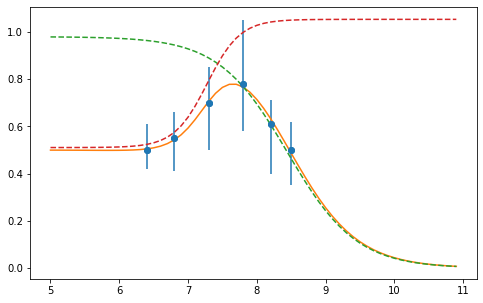

In [63]:
gg, mm, tt = growth(kk, pHs)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(pH, Herve_GR, marker='o',linestyle='None')
ax.errorbar(pH, Herve_GR, yerr=(Herve_Err1, Herve_Err2), marker='o',linestyle='None')
ax.plot(pHs, gg);
ax.plot(pHs, mm, color='tab:green', ls='--');
ax.plot(pHs, tt, color='tab:red', ls='--');

Thoughts?  Remember that the MM would go into the Leibig's Law of the Minimum and the tanh would be a multiplier like the Q10 for temperature.

We probably need to scale up the curve so on balance it goes through 1?  Or we will net decrease growth rates everywhere.

I should redo with a proper [CO2] calculation?  What other parameters should I use?